# Algorithmic Fairness in Practice
*Author: Charles (Charlie) Rice for Break Through Tech*

---


In module **9.4: Improve Fairness and Accountability** of your *Machine Learning Foundations* course in eCornell, you explored the concept of algorithmic fairness. This is the idea the machine learning systems should treat everyone equally, regardless of personal characteristics like race or sex. Algorithmic fairness assesments ask the question: which groups may be disproportionately negatively impacted by an AI system and in what ways? In other words, it is about understanding the potential harms that an AI system might perpetrate or perpetuate. The module used several examples of major failures of ethical AI like the COMPAS project, a predictive criminal sentencing model which ProPublica found produced different predictive errors for defendants of different races. The aim of algorithmic fairness is to ensure that AI/ML systems' outputs rely only on relevant factors and do not produce unavoidably disparate outcomes. For example, if a program helps decide who gets a loan, algorithmic fairness ensures that the decision isn't influenced by unfair or irrelevant factors like someone's background.

In this mini-lesson, we will introduce several tools that can be used for supporting fairness in machine learning projects. These tools have the advantage of being neatly quantitative, showing a clean number or plot that can 'show' how fair the model is. However, it should be noted, and will be noted throughout, that these methods are still experimental. Algorithmic fairness is fundamentally a socitotechnical challenge - one that cannot be approached purely socially or technologically. It is a multi-faceted and dynamic challenge, and no one approach or metric has been found (or may ever be found) that will 'solve' the problem for good and all.

For further discussion of the challenges inherent in algorithmic fairness, see: https://www.ajl.org/auditors

# Learning Objectives
By the end of this mini-lesson, you will be able to:

*   Understand the challenge of algorithmic fairness
*   Implement algorithmic fairness metrics using the [Fairlearn](https://fairlearn.org/) library
*   Implement some simple mitigations of algorithmic unfairness using the Fairlearn library

# Acknowledgments
The following mini-lesson is adapted from a tutorial, "Assessing and mitigating unfairness in AI systems" given by Manojit Nandi of the [Fairlearn team at PyCon 2022](https://github.com/fairlearn/talks/tree/main/2022_pycon). Note that the official tutorial is worth reading in its entirety as it includes a lot of additional information about the human side of algorithmic fairness than this mini-lesson will.



# Environment Setup

This tutorial assumes that you are working in a Google Colab environment. It will be necessary to re-start the runtime environment after running the following cell.

In [ ]:
# !pip install --upgrade fairlearn==0.7.0
# !pip install --upgrade scikit-learn>=1.0.0
# !pip install --upgrade seaborn
# !pip install --use-deprecated=legacy-resolver model-card-toolkit

As the last line says: restart the runtime once the cell above has finished running.

In [ ]:
# There are some futurewarnings that aren't relevant to our considerations. We'll suppress them
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd

pd.set_option("display.float_format", "{:.3f}".format)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()


In [ ]:
# Most of these tools are well known to us at this point
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay)
from sklearn import set_config

set_config(display="diagram")

In [ ]:
# The Fairlern package is new
from fairlearn.metrics import (
    MetricFrame,
    true_positive_rate,
    false_positive_rate,
    false_negative_rate,
    selection_rate,
    count,
    false_negative_rate_difference
)

from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds, TruePositiveRateParity

ModuleNotFoundError: No module named 'fairlearn'

In [ ]:
from IPython import display
from datetime import date

In [ ]:
try:
    from model_card_toolkit import ModelCardToolkit
    from model_card_toolkit.utils.graphics import figure_to_base64str
    import model_card_toolkit as mctlib
    model_card_imported = True
except Exception:
    model_card_imported = False
    def figure_to_base64str(*args):
        return None

We will be using a lot of standard tools, as you can see. But there are two new tools that you may not have seen before:

### Fairlearn
[Fairlearn is an open-source](https://fairlearn.org/), community-driven project to help improve AI systems. It got started as a Microsoft project in 2018 and transitioned to full community governance in 2021. It includes:

*   A Python library for fairness assessment and improvement (fairness metrics, mitigation algorithms, plotting, etc.)
*   Educational resources covering organizational and technical processes for unfairness mitigation (user guide, case studies, Jupyter notebooks, etc.)

### Model Card Toolkit
The [Model Card Toolkit](https://modelcards.withgoogle.com/about) (MCT)   streamlines and automates generation of model cards, machine learning documents that provide context and transparency into a model's development and performance. It was released by Google in 2020. NOTE: Although this lesson includes code from MCT, changes to the Keras/Tensorflow library have broken those sections. They are kept because it is a useful tool to be aware of.

# Dataset and Machine Learning Task
For this mini-lesson we will be using a [pre-processed clinical dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008) of hospital readmissions for patience with diabetes over a ten year period (1998-2008).

The features include a variety of demographic descriptors, descriptions of the admission type, the amount of time the patient spent in hospital, drugs prescribed, and how often the patient has been readmitted to the hospital.

We will be building a classification model on the recommendation for a high-risk care program. This presents our first challenge: we do not have a feature that directly measures that recommendation. Instead, we have to identify a proxy that we can measure. In this case it will be `readmit_30_days`.

Intuitively, this should make sense: a person who is readmitted to the hospital within a month of a prior admission probably has some serious health concerns. Intuition will suffice for now, but we will want at least some data to back up this decision.




# Load and Examine the Dataset

Let's take a look at the data we'll be using.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/fairlearn/talks/main/2021_scipy_tutorial/data/diabetic_preprocessed.csv")

In [ ]:
df.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary,readmit_30_days
0,Caucasian,Female,30 years or younger,Other,Referral,1,Other,41,0,1,...,No,No,False,False,False,False,False,NO,0,0
1,Caucasian,Female,30 years or younger,Discharged to Home,Emergency,3,Missing,59,0,18,...,Ch,Yes,False,False,False,False,False,>30,1,0
2,AfricanAmerican,Female,30 years or younger,Discharged to Home,Emergency,2,Missing,11,5,13,...,No,Yes,False,False,False,True,True,NO,0,0
3,Caucasian,Male,30-60 years,Discharged to Home,Emergency,2,Missing,44,1,16,...,Ch,Yes,False,False,False,False,False,NO,0,0
4,Caucasian,Male,30-60 years,Discharged to Home,Emergency,1,Missing,51,0,8,...,Ch,Yes,False,False,False,False,False,NO,0,0


Most of the features we have are binaries, booleans, or categoricals. Let's take a look at our possible values.

In [ ]:
# Show the values of all binary and categorical features
categorical_values = {}
for col in df:
  if col not in {'time_in_hospital', 'num_lab_procedures',
                 'num_procedures', 'num_medications', 'number_diagnoses'}:
    categorical_values[col] = pd.Series(df[col].value_counts().index.values)
categorical_values_df = pd.DataFrame(categorical_values).fillna('')
categorical_values_df.T

,0,1,2,3,4,5
race,Caucasian,AfricanAmerican,Unknown,Hispanic,Other,Asian
gender,Female,Male,Unknown/Invalid,,,
age,Over 60 years,30-60 years,30 years or younger,,,
discharge_disposition_id,Discharged to Home,Other,,,,
admission_source_id,Emergency,Referral,Other,,,
medical_specialty,Missing,Other,InternalMedicine,Emergency/Trauma,Family/GeneralPractice,Cardiology
primary_diagnosis,Other,Respiratory Issues,Diabetes,Genitourinary Issues,Musculoskeletal Issues,
max_glu_serum,Norm,>200,>300,,,
A1Cresult,>8,Norm,>7,,,
insulin,No,Steady,Down,Up,,


In [ ]:
categorical_features = [
    "race",
    "gender",
    "age",
    "discharge_disposition_id",
    "admission_source_id",
    "medical_specialty",
    "primary_diagnosis",
    "max_glu_serum",
    "A1Cresult",
    "insulin",
    "change",
    "diabetesMed",
    "readmitted"
]

In [ ]:
# Assign the correct datatype so that Python and pandas know what it's working with
for col_name in categorical_features:
  df[col_name] = df[col_name].astype("category")

EDA brings us to one of our first fairness considerations, which is the sample size of various groups within our dataset. As we know from our earlier work with machine learning, models learn the strongest patterns from the largest groups in our data. That is, groups that are heavily represented will show up the most in predictions.

Let's take a look at the `race` category.

In [ ]:
df["race"].value_counts()

,count
race,
Caucasian,76099
AfricanAmerican,19210
Unknown,2273
Hispanic,2037
Other,1506
Asian,641


In [ ]:
df["race"].value_counts(normalize=True)

,proportion
race,
Caucasian,0.748
AfricanAmerican,0.189
Unknown,0.022
Hispanic,0.020
Other,0.015
Asian,0.006


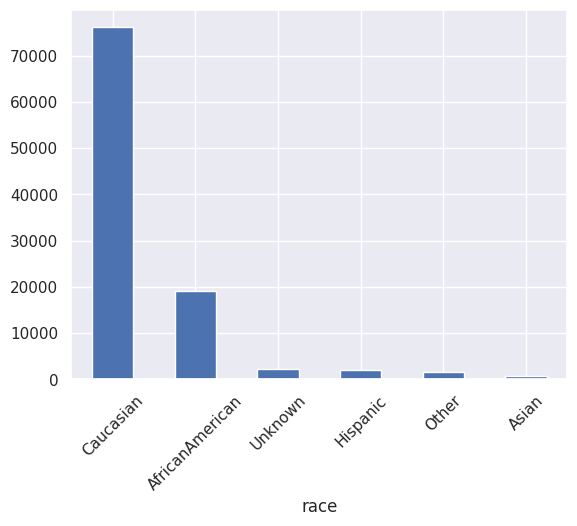

In [ ]:
df["race"].value_counts().plot(kind='bar', rot=45);

`Caucasian` is the largest `race` in our dataset here, with about 75% of the observations. The next largest group is `AfricanAmerican` with 19% of the patients.

The `race` category creates a decision point that pertains to fairness. `Hispanic`, `Other`, and `Asian` are relatively small groups. Dropping these groups altogether would create a harm of erasure, but merging them could mask other problems. We are going to merge these three, but also retain the original groups for further analysis.

In [ ]:
# retain the original race as race_all, and merge Asian+Hispanic+Other
df["race_all"] = df["race"]
df["race"] = df["race"].replace({"Asian": "Other", "Hispanic": "Other"})

We can also look at `gender`.

In [ ]:
df["gender"].value_counts() # counts

,count
gender,
Female,54708
Male,47055
Unknown/Invalid,3


In [ ]:
df["gender"].value_counts(normalize=True) # frequencies

,proportion
gender,
Female,0.538
Male,0.462
Unknown/Invalid,0.000


The `Unknown/Invalid` category is too small to perform a meaningful analysis, so we will drop it altogether. It's important to note that whenever you drop entire groups of data you make a note of it and explain why.

In [ ]:
df = df.query("gender != 'Unknown/Invalid'")

We should also take a look at our target variable, `readmit_30_days`, to see how it might correlate with other indicators of health, as well as potentially sensitive features in our dataset like `race` or `gender`. Two additional features - `had_emergency` and `had_inpatient_days` indicate further hospitalizations in the preceding year. They are probably helpful.

The vertical lines in the plots below indicate a 95% confidence interval generated through bootstrapping.

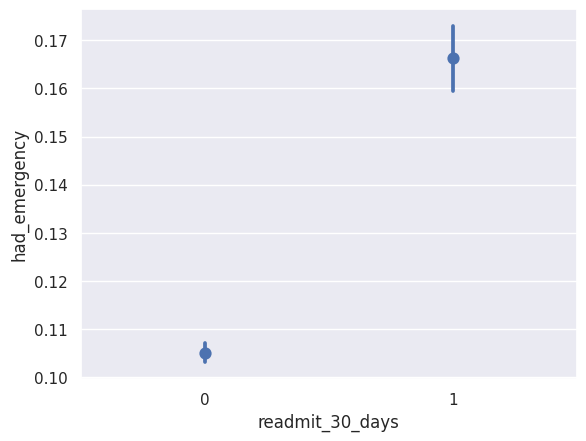

In [ ]:
sns.pointplot(y="had_emergency", x="readmit_30_days",
              data=df, ci=95, join=False);

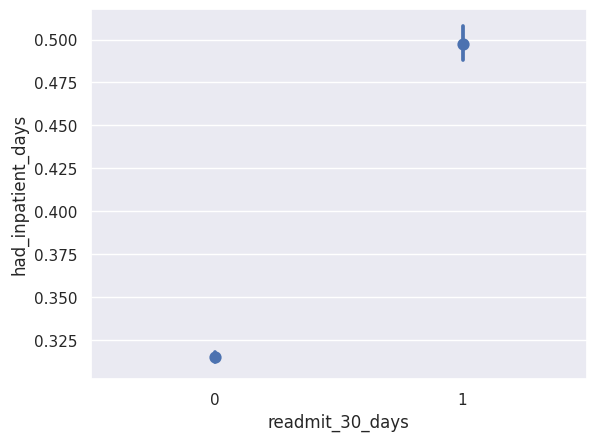

In [ ]:
sns.pointplot(y="had_inpatient_days", x="readmit_30_days",
              data=df, join=False);

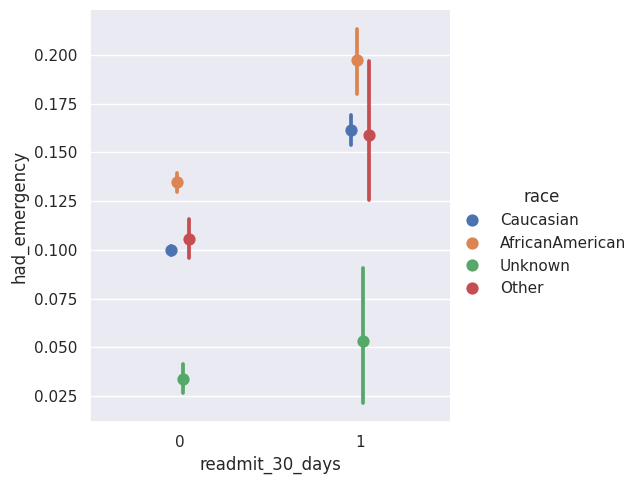

In [ ]:
sns.catplot(y="had_emergency", x="readmit_30_days", hue="race", data=df,
            kind="point", ci=95, dodge=True, join=False);

This additional EDA does indicate a strong relationship between our presumptive target variable, and other indicators of health, so it seems reasonable to proceed on that basis with modeling.

One last thing we need to check in EDA is the class balance, since we are predicting class labels.

In [ ]:
df["readmit_30_days"].value_counts()

,readmit_30_days
0,90406
1,11357


In [ ]:
df["readmit_30_days"].value_counts(normalize=True)

,readmit_30_days
0,0.888
1,0.112


It probably shouldn't surprise us that our dataset is quite imbalanced. The labels skew heavily towards a patient not being readmitted in 30 days. This means that we will have much larger uncertainty in our false negative rate (FNR) versus our false positive rate (FPR).

We can overcome a little bit of this imbalance by using *balanced error rate*, an average of FPR and FNR, as our target metric.

Analyzing group disparities plays a large role in assessing algorithmic fairness as we will see, so let's also take a look at the target broken down by the `race` category.

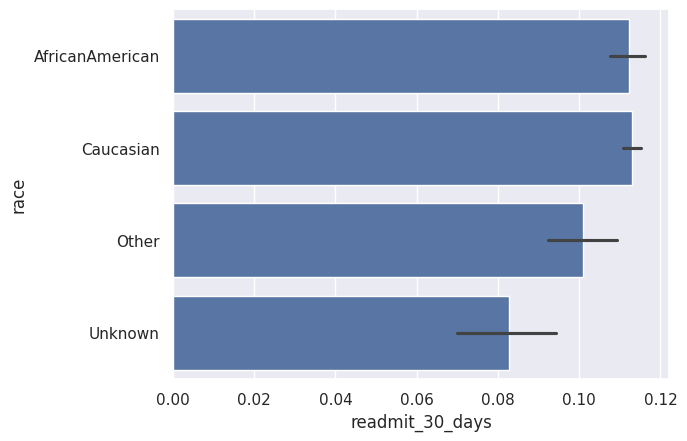

In [ ]:
sns.barplot(x="readmit_30_days", y="race", data=df, ci=95);

We can see here that the rate of `readmit_30_days` is about even for `AfricanAmerican` and `Caucasian`. Note as well that the error bars for `Other` and `Uknown` are larger, which reflects the smaller sample size and hence, greater uncertainty around the estimate.

# Initial Modeling

We now come to the discussion of modeling, and another decision point that can impact the fairness of our model's predictions. We already have our target variable, `readmit_30_days`, and we have a metric, *balanced accuracy* that will help account for the significant imbalance in our target class.

There are lots things that we need to consider when choosing an algorithm: the type of problem, the compute resources available, the business or scientific problem being analyzed. One of the major ones, especially when considering algorithmic fairness, is the final model's interpretability.

It's important that a model be open to stakeholder scrutiny for several reasons. First and foremost, a relatively simple and interpretable model allows for discovery of fairness issues that might have been missed during EDA or in framing the original problem. Second, it provides recourse to affected people. (The GDPR - Europe's data regulatory framework - actually requires that algorithmic decisions be appealable by affected persons.) And, finally, it allows for a 'sniff test' to see whether the final results actually make sense. This last point is especially important when the model is applied to different populations than it was developed on. For example, if a hospital decides to use this model, but it serves a predominantly Asian or Hispanic population, it may wind up producing different results than advertised.

In the interest of interpretability, then, we will use one of the simpler classification algorithms in our toolbox: **logistic regression**.



# Dataset Preparation

We know that we will need to split our data into training and testing sets. Since our data is largely composed of binary and categorical data, we will need to create dummies of many of our features.

Remember our target variable is `readmit_30_days` and we will be considering `race` as our sensitive feature. Calling out `race` here and elsewhere will enable us later to examine our results with more granularity to asses the fairness of our model and its possible harms.

In [ ]:
target_variable = "readmit_30_days"
demographic = ["race", "gender"]
sensitive = ["race"]

In [ ]:
Y, A = df.loc[:, target_variable], df.loc[:, sensitive]

Next, we drop the features that we *don't* want to use while dummy-ing the ones we do.

In [ ]:
X = pd.get_dummies(df.drop(columns=[
    "race",
    "race_all",
    "discharge_disposition_id",
    "readmitted",
    "readmit_binary",
    "readmit_30_days"
]))

In [ ]:
# Visual check that things look 'right'
X.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,...,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,1,41,0,1,1,False,False,False,False,False,...,1,0,0,1,0,0,0,1,1,0
1,3,59,0,18,9,False,False,False,False,False,...,1,0,0,0,0,1,1,0,0,1
2,2,11,5,13,6,False,False,False,True,True,...,1,0,0,1,0,0,0,1,0,1
3,2,44,1,16,7,False,False,False,False,False,...,1,0,0,0,0,1,1,0,0,1
4,1,51,0,8,5,False,False,False,False,False,...,1,0,0,0,1,0,1,0,0,1


Now, we split our data into train and test portions. You'll notice that not only are we splitting our X and our y matrices, but also the A matrix which was the one based on our sensitive feature `race`. We're also using an unusually large split for our test size, 50%, in order to ensure we have a sufficient sample size for our fairness assessment. In addition, we're stratifying on our target variable. You can see we're doing just about everything we can to balance our very imbalanced data.

In [ ]:
random_seed = 445
np.random.seed(random_seed)

In [ ]:
X_train, X_test, Y_train, Y_test, A_train, A_test, df_train, df_test = train_test_split(
    X,
    Y,
    A,
    df,
    test_size=0.50,
    stratify=Y,
    random_state=random_seed
)

Although using **balanced accuracy** will help with our class imbalances, we are also going to resample our dataset for training (but not evaluation). This will allow us to use estimators that optimize for standard accuracy. It also downsamples the negative case, which will reduce the number of data points available. If we used a more complex estimator than logistic regression, our accuracy might suffer on account of this resample

In [ ]:
def resample_dataset(X_train, Y_train, A_train):

  negative_ids = Y_train[Y_train == 0].index
  positive_ids = Y_train[Y_train == 1].index
  balanced_ids = positive_ids.union(np.random.choice(a=negative_ids, size=len(positive_ids)))

  X_train = X_train.loc[balanced_ids, :]
  Y_train = Y_train.loc[balanced_ids]
  A_train = A_train.loc[balanced_ids, :]
  return X_train, Y_train, A_train

In [ ]:
X_train_bal, Y_train_bal, A_train_bal = resample_dataset(X_train, Y_train, A_train)

# Save Descriptive Statistics of Training and Testing Data

Part of our effort to maintain interpretability requires that we save descriptive statistics of our training dataset. The `figure_to_base64str()` function comes from the [Model Card Toolkit](https://github.com/tensorflow/model-card-toolkit/blob/main/model_card_toolkit/documentation/guide/concepts.md); it's encoding a plot as a string so that it can be exported later.

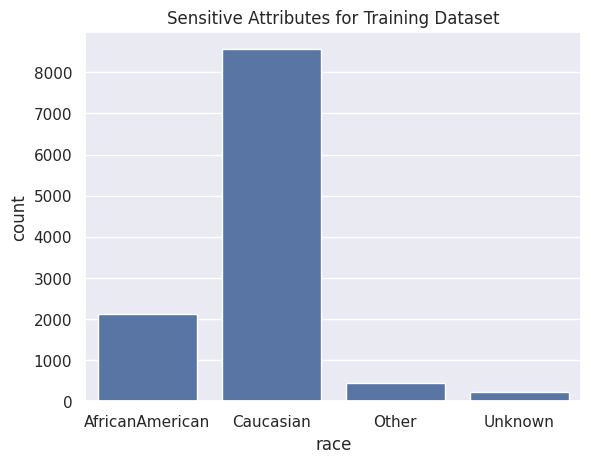

In [ ]:
sns.countplot(x="race", data=A_train_bal)
plt.title("Sensitive Attributes for Training Dataset")
sensitive_train = figure_to_base64str(plt)

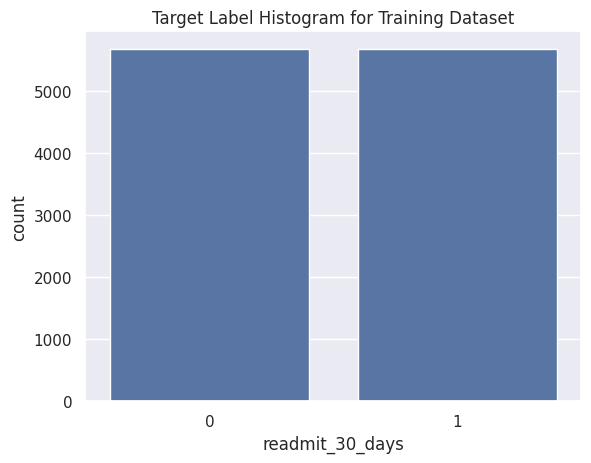

In [ ]:
sns.countplot(x=Y_train_bal)
plt.title("Target Label Histogram for Training Dataset")
outcome_train = figure_to_base64str(plt)

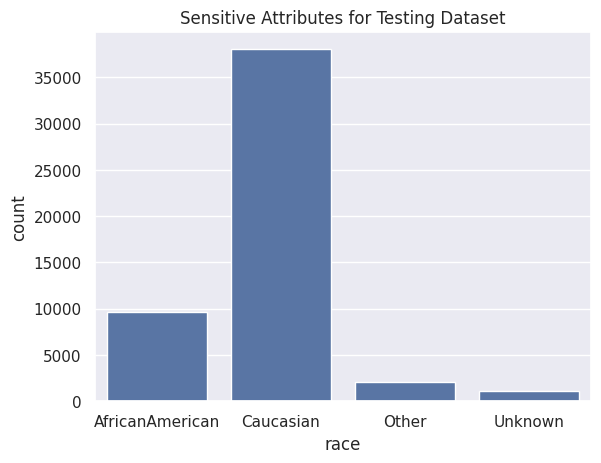

In [ ]:
sns.countplot(x="race", data=A_test)
plt.title("Sensitive Attributes for Testing Dataset")
sensitive_test = figure_to_base64str(plt)

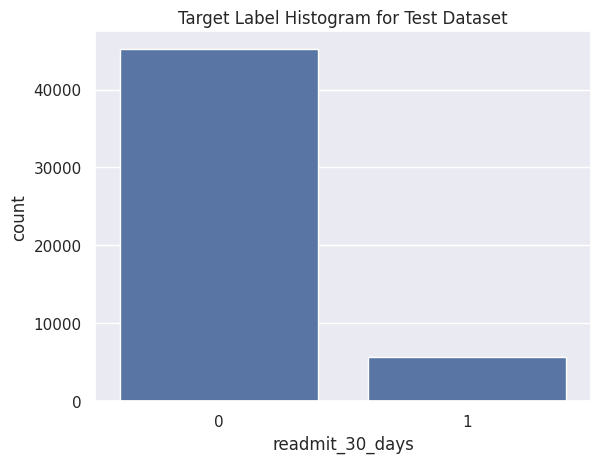

In [ ]:
sns.countplot(x=Y_test)
plt.title("Target Label Histogram for Test Dataset")
outcome_test = figure_to_base64str(plt)

# Train the model

We now come to the actual training! We're, again, using a simple logistic regression inside of a pipeline.

In [ ]:
unmitigated_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("logistic_regression", LogisticRegression(max_iter=1000))
])

In [ ]:
unmitigated_pipeline.fit(X_train_bal, Y_train_bal)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('logistic_regression', LogisticRegression(max_iter=1000))])

In [ ]:
Y_pred_proba = unmitigated_pipeline.predict_proba(X_test)[:,1]
Y_pred = unmitigated_pipeline.predict(X_test)

Now we check out model's performance on the test data using the ROC curve.

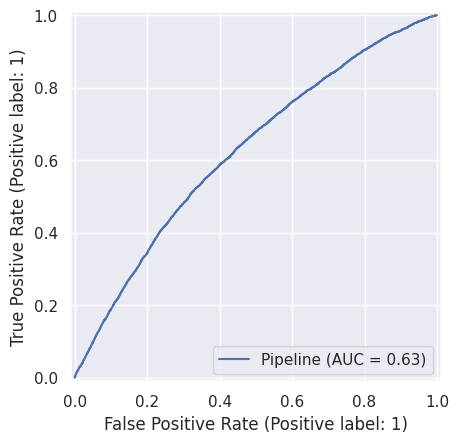

In [ ]:
# Plot ROC curve of probabilistic predictions
unmitigated_roc = RocCurveDisplay.from_estimator(unmitigated_pipeline, X_test, Y_test)

In [ ]:
# Balanced accuracy
balanced_accuracy_score(Y_test, Y_pred)


0.5938559464392199

As we can see, this basic model does reasonably well. It's better than a 50/50 coin flip, but it is far from perfect.

Part of our assessment, not just for modeling but also for fairness, should include an assessment of the coefficients. This is a somewhat subjective approach, but can help us to highlight issues early in the process.

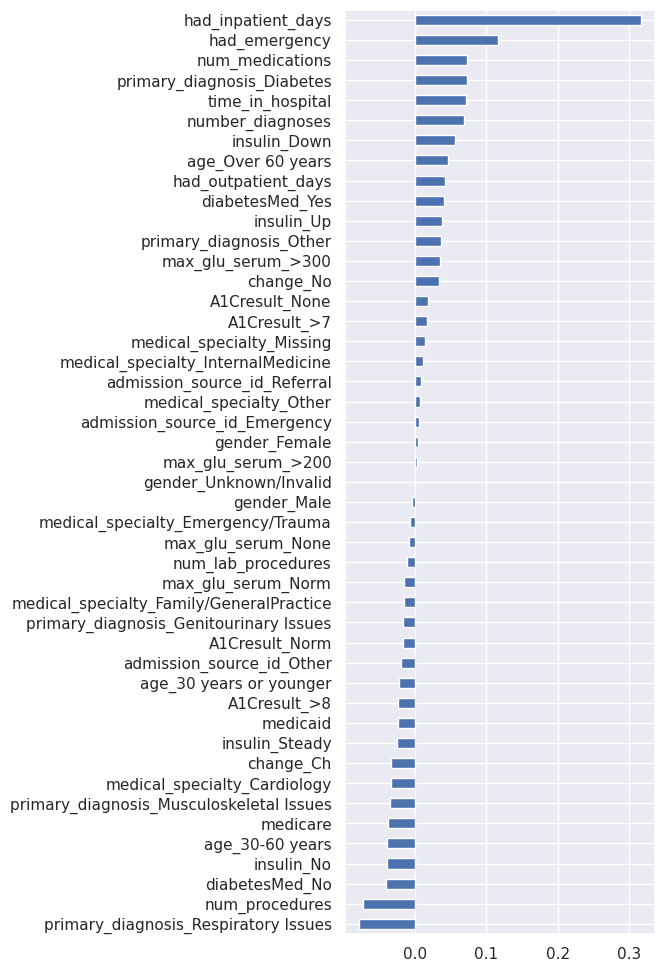

In [ ]:
coef_series = pd.Series(data=unmitigated_pipeline.named_steps["logistic_regression"].coef_[0], index=X.columns)
coef_series.sort_values().plot.barh(figsize=(4, 12), legend=False);

# Fairness Assessment

Recall that fairness is about identifying and mitigating the potential harms of an AI system. A simple look at coefficients or the AUC-ROC curve won't tell us much about those harms. Instead, we have to ask questions of the model, its results, and predictions following a set of steps.


1.   Identify harms
2.   Identify the groups that might be harmed
3.   Quantify those harms
4.   Compare quantified harms across groups

## 1. Identify Harms
Our example involves medical care - identifying patients likely to benefit from a more involved care regime for diabetes. In this case, harm would come from patients who *should* be recommended for additional care but are not. In other words, harm comes from the **false negatives**.

## 2. Identify the Groups That Might Be Harmed
Historically marginalized demographic groups - such as sexual or racial groups - are typically the groups we are most concerned with in fairness assesments. But harm can change based on the machine learning application. A transcription app that has only been trained on the diction of native speakers might harm non-native speakers of a language, or speakers of a less-common dialect. We also have to consider the intersection of group identity, like the impact of a model specifically on Black women.

In our specific example we built a model around `race`, but the tools we are using can be expanded to include those intersections.

## 3. Quantify Harms
In this step, we need to identify metrics that are likely to line up with harm. However, we don't always get data specifically on the harms and so we have to use proxies, as we did using `readmit_30_days`. In our healthcare case, we are assuming that every patient would benefit equally from the additional care regimen, which backs up our decision to use false negatives as a metric for harm.

We could also look at a **selection rate** - the overall fraction of patients recommended for additional care, regardless of whether they were a positive case in `readmit_30_days`. This metric would actually quantify benefit, rather than harm, and could alert us to disparities in how the benefit is allocated.

## 4. Compare Quantified Harms Across Groups
The main tool of fairness assessment, you may have guessed, is disaggregation. We need to separate groups out of our data to see how there might be disparities in results. Fairlearn provides the tools that enable us to slice up our data by groups to see how our model performs not just on the whole, but on specific subsets. We can then summarize the disparities in performances with calculated values like the difference between groups or the ratio of the best to the worst slices of the data.

We might want ultimately to summarize those quantified differences in a table, like so:


| | false negative rate<br>(FNR) |
|---|---|
| AfricanAmerican | 0.43 |
| Caucasian | 0.44 |
| Other | 0.52 |
| Unknown | 0.67 |
| | |
|_largest difference_| 0.24 &nbsp;&nbsp;(best is 0.0)|
|_smallest ratio_| 0.64 &nbsp;&nbsp;(best is 1.0)|
|_maximum_<br>_(worst-case) FNR_|0.67|


# Fairness Assessment with `MetricFrame`

The [Fairlearn library](https://fairlearn.org/) provides a host of tools to support fairness assessments, and follows the standard sklearn syntax. The main workhorse is `MetricFrame` a data structure that enables disaggregated comparision of groups of data. In this instance, we will build a `MetricFrame` on our trained logistic regression to identify potential fairness-related harms.

In simplest terms, the `MetricFrame` function takes four arguments:

```python
metric_function with signature metric_function(y_true, y_pred)
y_true: array of labels
y_pred: array of predictions
sensitive_features: array of sensitive feature values
```
`sensitive_features` is a list of columns (at least one column) containing the group of interest. In our case, `race` but it can be extended to multiple features.

In [ ]:


mf1 = MetricFrame(metrics=false_negative_rate,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['race'])

# The disaggregated metrics are stored in a pandas Series mf1.by_group:

mf1.by_group

,false_negative_rate
race,
AfricanAmerican,0.428
Caucasian,0.442
Other,0.523
Unknown,0.670


We can access the best, worst, and smallest performance metrics like so:

In [ ]:
print(f"difference: {mf1.difference():.3}\n"
      f"ratio: {mf1.ratio():.3}\n"
      f"max across groups: {mf1.group_max():.3}")

difference: 0.242
ratio: 0.639
max across groups: 0.67


And we can access multiple metrics by providing `MetricFrame` with a dictionary:

In [ ]:
metrics_dict = {
    "selection_rate": selection_rate,
    "false_negative_rate": false_negative_rate,
    "balanced_accuracy": balanced_accuracy_score,
}

metricframe_unmitigated = MetricFrame(metrics=metrics_dict,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['race'])

# The disaggregated metrics are then stored in a pandas DataFrame:

metricframe_unmitigated.by_group

,selection_rate,false_negative_rate,balanced_accuracy
race,,,
AfricanAmerican,0.400,0.428,0.597
Caucasian,0.391,0.442,0.594
Other,0.328,0.523,0.584
Unknown,0.263,0.670,0.536


In [ ]:
# The largest difference, smallest ratio, and the maximum and minimum values
# across the groups are then all pandas Series, for example:

metricframe_unmitigated.difference()

,0
selection_rate,0.137
false_negative_rate,0.242
balanced_accuracy,0.061


In [ ]:
pd.DataFrame({'difference': metricframe_unmitigated.difference(),
              'ratio': metricframe_unmitigated.ratio(),
              'group_min': metricframe_unmitigated.group_min(),
              'group_max': metricframe_unmitigated.group_max()}).T

,selection_rate,false_negative_rate,balanced_accuracy
difference,0.137,0.242,0.061
ratio,0.657,0.639,0.898
group_min,0.263,0.428,0.536
group_max,0.400,0.670,0.597


And with the disaggregated metrics collected in one place, they can be easily plotted using standard plotting libraries:

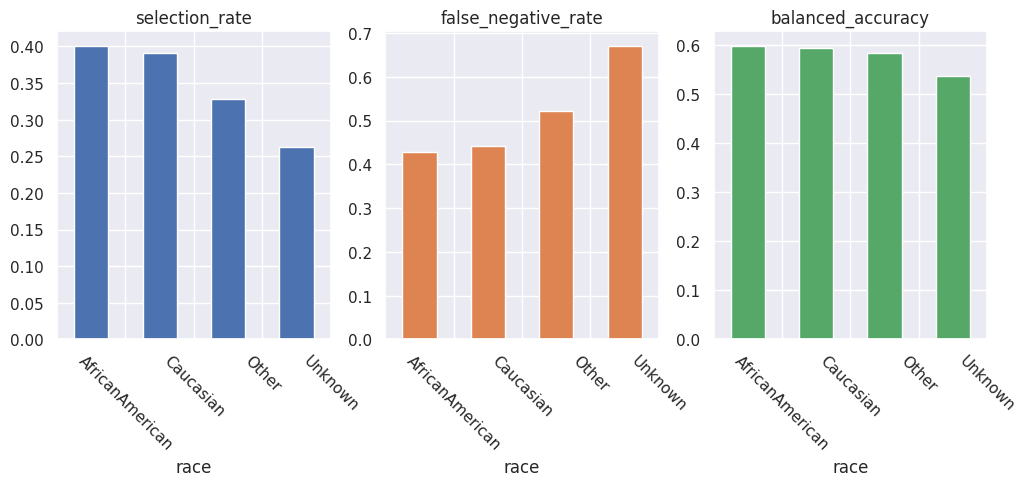

In [ ]:
metricframe_unmitigated.by_group.plot.bar(subplots=True, layout= [1,3], figsize=(12, 4),
                      legend=False, rot=-45, position=1.5);

We can see from the barplot that there is some disparity among the groups observed. The `Unknown` group has the lowest selection rate and balanced accuracy score as well as the highest false negative rate. However, the fact of disparity is not strict proof of harm or unfairness. There are several reasons that could explain the disparity, such as the smallness of the sample or differences in the feature distribution. Again: fairness is seldom an issue of clear, straightforward metrics and requires a lot of human judgment and discernment.

# Exercise

It's your turn now to train a fairness-unaware model and evaluate itusing the `MetricFrame`. Take this opportunity to look at a different sensitive feature such as `age` or `gender` or the intersectionality of several features.

We're going to use a different algorithim this time, the Histogram Gradient Boosting Classifier. This is an ensemble method that improves the efficiency of the traditional gradient boosting algorithm by discretizing continuous input features into bins (histograms).

1) First, let's train our machine learning model and fit it to the balanced training data set.

In [ ]:
# For Students
from sklearn.ensemble import HistGradientBoostingClassifier

Create your model here
clf = HistGradientBoostingClassifier()

Fit the model to the training data
clf.fit(__________, ________)
exercise_pred = clf.predict(______)

<details>
<summary>
Solution
</summary>
<br>
from sklearn.ensemble import HistGradientBoostingClassifier

### Create your model here
clf = HistGradientBoostingClassifier()

### Fit the model to the training data
clf.fit(X_train_bal, Y_train_bal)
exercise_pred = clf.predict(X_test)
</details>

2) Next, let's evaluate the fairness of the model using the `MetricFrame`. In the below cells, create a `MetricFrame` that looks at the following metrics:


*   _Count_: The number of data points belonging to each sensitive feature category.
*   _False Positive Rate_: $\dfrac{FP}{FP+TN}$
*  _Recall Score_: $\dfrac{TP}{TP+FN}$

As an extra challenge, you can use the prediction probabilities to compute the _ROC AUC Score_ for each sensitive group pair.



In [ ]:
## For Students
#exercise_metrics = {
#    "count": count,
#    "false_positive_rate": _______,
#    "recall_score": _______
#}

<details>
<summary>Solution</summary>
<br>
# Define additional fairness metrics of interest here
exercise_metrics = {
    "count": count,
    "false_positive_rate": false_positive_rate,
    "recall_score": recall_score
}
</details>

Now, let's create our `MetricFrame` using the metrics listed above with the sensitive groups of `race` and `gender`.

In [ ]:
# For Students
metricframe_exercise = MetricFrame(
   metrics=__________,
   y_true=Y_test,
   y_pred=__________,
   sensitive_features=_____
)

<details>
<summary>Solution</summary>
<br>
# Create a MetricFrame on your model's results
metricframe_exercise = MetricFrame(
    metrics=exercise_metrics,
    y_true=Y_test,
    y_pred=exercise_pred,
    sensitive_features=A_test
)
</details>

3) Finally, play around with the plotting capabilities of the `MetricFrame` in the below section.

<details>
<summary>
Solution
</summary>
<br>
metricframe_exercise.by_group
</details>

In [ ]:
# For Students
metricframe_exercise._______

array([[<Axes: title={'center': 'count'}, xlabel='race'>,
        <Axes: title={'center': 'false_positive_rate'}, xlabel='race'>,
        <Axes: title={'center': 'recall_score'}, xlabel='race'>,
        <Axes: xlabel='race'>]], dtype=object)

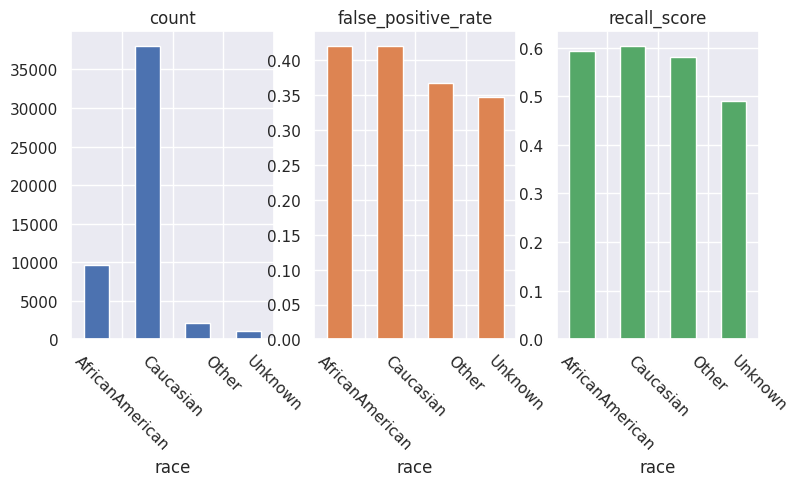

In [ ]:
# Plot some of the performance disparities here
metricframe_exercise.by_group.plot.bar(subplots=True, layout=[1,4], figsize=(12, 4),
                                       legend=False, rot=-45, position=1.5)

In [ ]:
## For Students
Plot some of the performance disparities here
metricframe_exercise.by_group.____.bar(subplots=_____, layout=[1,4], figsize=(12, 4), legend=False, rot=-45, position=1.5)

Do note that these charts are based on test data, so without some kind of uncertainty quantification like a CI or an error bar we cannot compare these statistics.

# Mitigating Unfairness in ML Models

At this point we have only identified unfairness, or possible unfairness, in machine learning models. We have discussed in passing ways that we could mitigate this unfairness at the human level (task definition, data collection), but what about the algorithmic level?

Fairlearn also includes tools that can help reduce unfairness. Mitigation can happen really at any of three stages: during preprocessing, when we can try to transform the training data to be inherently less unfair; at training time by adding fairness constraints to our algorithm; or during postprocessing, where the output is modified to meet some criteria.

In this section, we will look at approaches that apply at training time and at postprocessing.

# Postprocessing Mitigation with `ThresholdOptimizer`

Ideally, the data we collect and the model that we train are as fair as we can reasonably make them. But we have to do machine learning in the real world and that frequently means that due to privacy, regulatory, or other concerns we can only mitigate unfairness after the model has been trained.

The `ThresholdOptimizer` takes an existing model and identifies separate thresholds for each sensitive group to optimize a specified metric, like balanced accuracy, under some constraint like false negative rate parity, which requires that all groups have equal false negative rates.

The function takes in the existing estimator, the constraints we wish to satisfy, and an objective metric that we want to maximize.

In [ ]:
# Let's instantiate a ThresholdOptimizer with the Logistic Regression we trained earlier
postprocess_est = ThresholdOptimizer(
    estimator=unmitigated_pipeline,
    constraints="false_negative_rate_parity",
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method='predict_proba'
)

The `ThresholdOptimizer` requires that we identify the sensitive group(s) or feature(s) in our data, which is why we called them out specifically during our preprocessing. But we also need to be able to use it when the model is deployed and running in the real world. This is not always possible, as privacy, security, or regulatory requirements might prevent us from using a "sensitive" category like race or sex.

We can fit the `ThresholdOptimizer` exactly as we fit any other sklearn transformer.

In [ ]:
postprocess_est.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)

ThresholdOptimizer(constraints='false_negative_rate_parity',
                   estimator=Pipeline(steps=[('preprocessing',
                                              StandardScaler()),
                                             ('logistic_regression',
                                              LogisticRegression(max_iter=1000))]),
                   objective='balanced_accuracy_score',
                   predict_method='predict_proba', prefit=True)

For transparencey and explainability, we want to save this transformation as its own object:

In [ ]:
Y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=A_test)
metricframe_postprocess = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred_postprocess,
    sensitive_features=A_test
)

And we can now start inspecting our results:

In [ ]:
pd.concat([metricframe_unmitigated.by_group,
           metricframe_postprocess.by_group],
           keys=['Unmitigated', 'ThresholdOptimizer'],
           axis=1)

Unmitigated                                        \
                selection_rate false_negative_rate balanced_accuracy   
race                                                                   
AfricanAmerican          0.400               0.428             0.597   
Caucasian                0.391               0.442             0.594   
Other                    0.328               0.523             0.584   
Unknown                  0.263               0.670             0.536   

                ThresholdOptimizer                                        
                    selection_rate false_negative_rate balanced_accuracy  
race                                                                      
AfricanAmerican              0.426               0.404             0.597  
Caucasian                    0.451               0.389             0.590  
Other                        0.411               0.419             0.595  
Unknown                      0.468               0.415             0.564

Let's zoom in on an area of interest: the difference between the largest and smallest metric values:

In [ ]:
pd.concat([metricframe_unmitigated.difference(),
           metricframe_postprocess.difference()],
          keys=['Unmitigated: difference', 'ThresholdOptimizer: difference'],
          axis=1).T

,selection_rate,false_negative_rate,balanced_accuracy
Unmitigated: difference,0.137,0.242,0.061
ThresholdOptimizer: difference,0.057,0.030,0.033


As we can see, the difference between the FNR of the `ThresholdOptimizer` and the Unmitigated model is significant. If we wanted to be very thorough with our validation, we could run the ThresholdOptimizer on the training data as well to see how it differs from our test data.

Let's be sure to save our disaggregated statistics:

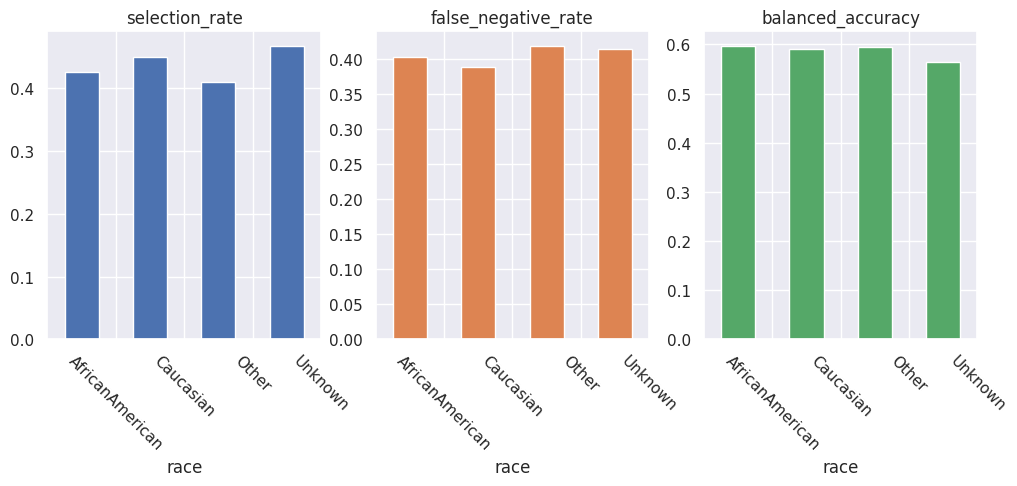

In [ ]:
metricframe_postprocess.by_group.plot.bar(subplots=True, layout=[1,3], figsize=(12, 4), legend=False, rot=-45, position=1.5)
postprocess_performance = figure_to_base64str(plt)

# Exercise: `ThresholdOptimizer`

Now, let's try a different `ThresholdOptimizer` constraining the *true positive rate` (aka the *recall score*).

1) Create a `ThresholdOptimizer` with the constraint `true_positive_parity` and an objective function (scoring metric) `balanced_accuracy_score`.

In [ ]:
# For Students
thresopt_exercise = ThresholdOptimizer(
   estimator=______________,
   constraints=____________,
   objective="balanced_accuracy_score",
   prefit=True,
   predict_method='predict_proba'
)

In [ ]:
thresopt_exercise.____(X_train_bal, Y_train_bal, sensitive_features=_______)
threshopt_pred = thresopt_exercise._________(X_test, sensitive_features=_______)

<details>
<summary>Solution</summary>
<br>
# Instantiate ThresholdOptimizer
thresopt_exercise = ThresholdOptimizer(
    estimator=unmitigated_pipeline,
    constraints="true_positive_rate_parity",
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method='predict_proba'
)

# Fit to data and predict on test data
thresopt_exercise.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)
threshopt_pred = thresopt_exercise.predict(X_test, sensitive_features=A_test)
</details>

2) Create a new `MetricFrame` object to process and present the disaggregated results for this new classifier.

In [ ]:
# For Students
thresop_metricframe = MetricFrame(
   metrics=metrics_dict,
   y_true=Y_test,
   y_pred=____________,
   sensitive_features=_______
)

<details>
<summary>Solution</summary>
<br>
thresop_metricframe = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=threshopt_pred,
    sensitive_features=A_test
)
</details>

3) Finally, compare the results of the two `ThresholdOptimizers`.

In [ ]:
## For Students
## Visualize the performance of the new ThresholdOptimizer
#thresop_metricframe._______

In [ ]:
## Compare the performance to the original ThresholdOptimizer
#metricframe_postprocess.______

<details>
<summary>Solution</summary>
<br>
# Visualize the performance of the new ThresholdOptimizer
thresop_metricframe.by_group

# Compare the performance to the original ThresholdOptimizer
metricframe_postprocess.by_group
</details>

# The Reductions Approach Using `ExponentiatedGRadient`

The `ThresholdOptimizer` is a postprocessing method for satisfying fairness constraints.  It is clearly effective, as we can see in the reduction of the *false negative rate* in our sample above. Unfortunately, it requires that we be able to use the sensitive features we are worried about. This is not always possible due to legal, privacy, or other security or ethical concerns.

The reductions approach allows us to satisfy fairness constraints without having access to sensitive features at deployment time. The main tool for this approach is `ExponentiatedGradient`. Like `ThresholdOptimizer` this is a code wrapper that takes in an estimator and the fairness constraints. Unlike `ThresholdOptimizer` the estimator we pass in is 'empty' - it hasn't been fit to data yet. It also allows a bit more flexibility in the constraint, as we will see.

In [ ]:
expgrad_est = ExponentiatedGradient(
    estimator=LogisticRegression(max_iter=1000, random_state=random_seed),
    constraints=TruePositiveRateParity(difference_bound=0.02)
)

The `difference_bound` parameter enables us to set a threshold, rather than requiring the absolute parity (a difference of zero) between the largest and smallest true positive rate across all groups.

Once it has been instantiated, we can `fit` the `ExponentiatedGradient`.

In [ ]:
expgrad_est.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.TruePositiveRateParity object at 0x7c55723bedd0>,
                      estimator=LogisticRegression(max_iter=1000,
                                                   random_state=445),
                      nu=0.0023032688195902583)

Note that, like `ThresholdOptimizer`, the predictions of `ExponentiatedGradient` are randomized. To ensure reproducible results, we need to make use of the `random_state` variable in the `predict` method:

In [ ]:
# Generate Predictions
Y_pred_reductions = expgrad_est.predict(X_test, random_state=random_seed)

# Record predictions to a MetricFrame
metricframe_reductions = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred_reductions,
    sensitive_features=A_test
)

# View the MetricFrame
metricframe_reductions.by_group

,selection_rate,false_negative_rate,balanced_accuracy
race,,,
AfricanAmerican,0.405,0.426,0.596
Caucasian,0.399,0.441,0.590
Other,0.339,0.514,0.582
Unknown,0.339,0.574,0.547


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('selection_rate').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('false_negative_rate').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('balanced_accuracy').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['false_negative_rate'].value_counts()
    for x_label, grp in _df_3.groupby('selection_rate')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('selection_rate')
_ = plt.ylabel('false_negative_rate')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['balanced_accuracy'].value_counts()
    for x_label, grp in _df_4.groupby('false_negative_rate')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('false_negative_rate')
_ = plt.ylabel('balanced_accuracy')

In [ ]:
# Evaluate the difference between the largest and smallest value of each metric
metricframe_reductions.difference()

,0
selection_rate,0.066
false_negative_rate,0.148
balanced_accuracy,0.049


The `ExponentiatedGradient` model does show some improvement in the false negative rate, versus the unmitigated model, but it's not huge. The advantage is that we can offer some mitigation without including the sensitive feature at deployment time.

# Break Out Individual Predictors

`ExponentiatedGradient` is an ensemble method: it iteratively trains multiple predictors on a re-weighted training dataset. Each of these predictors is stored, and the model randomizes among them at deployment time.

This randomnes is not always desirable, however, and can pose problems for interpretability. The Fairlearn library allows us to explore individual predictors and examine them. Note that since the base model is a Logistic Regression, all the models will be Logistic Regressions.

In [ ]:
predictors = expgrad_est.predictors_
predictors

,0
0,"LogisticRegression(max_iter=1000, random_state..."
1,"LogisticRegression(max_iter=1000, random_state..."
2,"LogisticRegression(max_iter=1000, random_state..."
3,"LogisticRegression(max_iter=1000, random_state..."
4,"LogisticRegression(max_iter=1000, random_state..."
5,"LogisticRegression(max_iter=1000, random_state..."
6,"LogisticRegression(max_iter=1000, random_state..."
7,"LogisticRegression(max_iter=1000, random_state..."
8,"LogisticRegression(max_iter=1000, random_state..."
9,"LogisticRegression(max_iter=1000, random_state..."


In [ ]:
# Collect predictions by all predictors and calculate balanced error
# as well as the false negative difference for all of them

sweep_preds = [clf.predict(X_test) for clf in predictors]
balanced_error_sweep = [1-balanced_accuracy_score(Y_test, Y_sweep) for Y_sweep in sweep_preds]
fnr_diff_sweep = [false_negative_rate_difference(Y_test, Y_sweep, sensitive_features=A_test) for Y_sweep in sweep_preds]

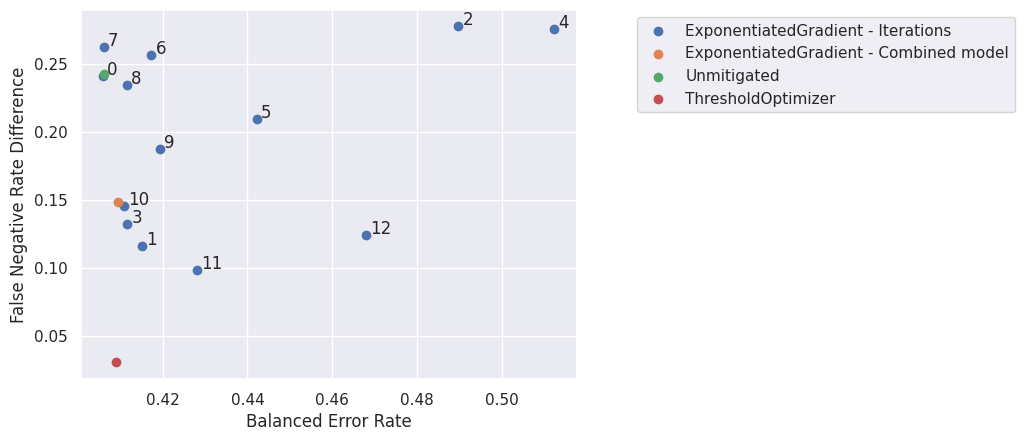

In [ ]:
# Show the balanced error / fnr difference values of all predictors on a raster plot

plt.scatter(balanced_error_sweep, fnr_diff_sweep, label="ExponentiatedGradient - Iterations")
for i in range(len(predictors)):
  plt.annotate(str(i), xy=(balanced_error_sweep[i]+0.001, fnr_diff_sweep[i]+0.001))

# Also include in the plot the combined ExponentiatedGradient model
# as well as the three previously fitted models

plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred_reductions),
            false_negative_rate_difference(Y_test, Y_pred_reductions, sensitive_features=A_test),
            label="ExponentiatedGradient - Combined model")
plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred),
            false_negative_rate_difference(Y_test, Y_pred, sensitive_features=A_test),
            label="Unmitigated")
plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred_postprocess),
            false_negative_rate_difference(Y_test, Y_pred_postprocess, sensitive_features=A_test),
            label="ThresholdOptimizer")

plt.xlabel("Balanced Error Rate")
plt.ylabel("False Negative Rate Difference")
plt.legend(bbox_to_anchor=(1.9,1))
plt.show()

# Exercise: Train an `ExponentiatedGradient` Model

Your turn! Once again, you're going to instantiate and train a new `ExponentiatedGradient` model using the base `HistGradientBoostingClassifier` and the same `difference_bound` as before.

1) First we instantiate the `ExponentiatedGradient` and fit it to the training data.

In [ ]:
# For Students
# Create ExponentiatedGradient instance here
expgrad_exercise = ExponentiatedGradient(
   estimator=_______,
   constraints=TruePositiveRateParity(difference_bound=____)
)

In [ ]:
expgrad_exercise.fit(________, _________, sensitive_features=________)

<details>
<summary>Solution</summary>
<br>
## Create ExponentiatedGradient instance here
expgrad_exercise = ExponentiatedGradient(
    estimator=HistGradientBoostingClassifier(),
    constraints=TruePositiveRateParity(difference_bound=0.02)
)

## Fit the new instance to the balanced training dataset
expgrad_exercise.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)
</details>

2) Let's see how the model did compared to the logistic regression version.

In [ ]:
# For Students
Y_expgrad_exercise = expgrad_exercise.predict(X_test)
mf_expgrad_exercise = MetricFrame(
   metrics=________,
   y_true=Y_test,
   y_pred=_______,
   sensitive_features=________
)
mf_expgrad_exercise.______

<details>
<summary>Solution</summary>
<br>
## Save the predictions and report the disagregated metrics
## of the exponantiated gradient model
Y_expgrad_exercise = expgrad_exercise.predict(X_test)
mf_expgrad_exercise = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_expgrad_exercise,
    sensitive_features=A_test
)
mf_expgrad_exercise.by_group

# Compare with the disaggregated metric values of the
# exponentiated gradient model based on logistic regression
metricframe_reductions.by_group
</details>

3) Now, we'll calculate the balanced accuracy rate and the false negative rate for all of the internal models learned by the `ExponentiatedGradient`.

In [ ]:
# Save the inner predictors of the new model
predictors_exercise = expgrad_exercise.predictors_

In [ ]:
# For Students
balanced_error_exercise = [(1 - ______(Y_test, pred.predict(X_test))) for pred in predictors_exercise]
false_neg_exercise = [(______(Y_test, pred.predict(X_test), sensitive_features=_____)) for pred in predictors_exercise]

<details>
<summary>Solution</summary>
<br>
# Compute the balanced error rate and false negative rate difference for each of the predictors on the test data.
balanced_error_exercise = [(1 - balanced_accuracy_score(Y_test, pred.predict(X_test))) for pred in predictors_exercise]
false_neg_exercise = [(false_negative_rate_difference(Y_test, pred.predict(X_test), sensitive_features=A_test)) for pred in predictors_exercise]
</details>

4) Finally, we compare the performances of the individual internal modles against their corresponding unmitigated version.

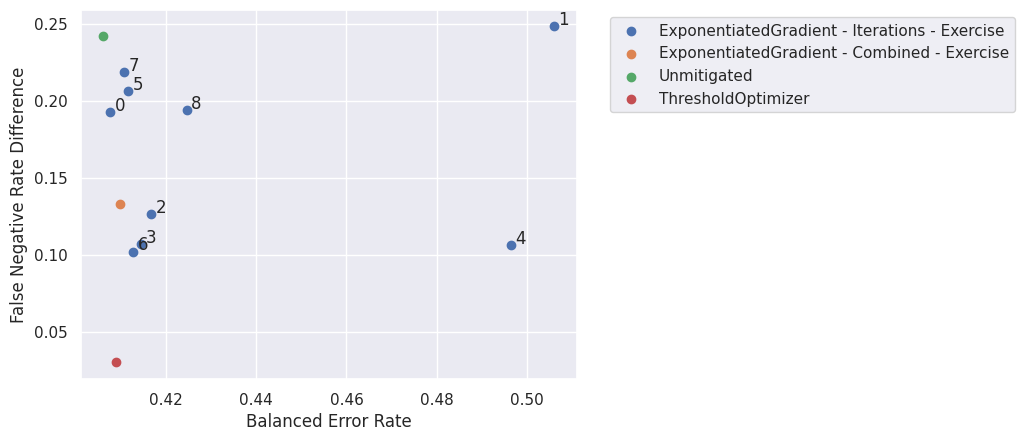

In [ ]:
# Plot the individual predictors against the Unmitigated Model and the ThresholdOptimizer
plt.scatter(balanced_error_exercise, false_neg_exercise,
            label="ExponentiatedGradient - Iterations - Exercise")
for i in range(len(predictors_exercise)):
  plt.annotate(str(i), xy=(balanced_error_exercise[i]+0.001, false_neg_exercise[i]+0.001))

plt.scatter(1-balanced_accuracy_score(Y_test, Y_expgrad_exercise),
            false_negative_rate_difference(Y_test, Y_expgrad_exercise, sensitive_features=A_test),
            label="ExponentiatedGradient - Combined - Exercise")
plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred),
            false_negative_rate_difference(Y_test, Y_pred, sensitive_features=A_test),
            label="Unmitigated")
plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred_postprocess),
            false_negative_rate_difference(Y_test, Y_pred_postprocess, sensitive_features=A_test),
            label="ThresholdOptimizer")

plt.xlabel("Balanced Error Rate")
plt.ylabel("False Negative Rate Difference")
plt.legend(bbox_to_anchor=(1.9,1))
plt.show()

# Compare the Peformance of `ThresholdOptimizer` and `ExponentiatedGradient`

Let's see how the two techniques work. Remember, though, that metrics will only ever tell part of the story. It's still down to a human data scientist or other subject matter expert to make the judgment call, to identify what's important, and to decide whether the mitigation is sufficient.

### Model Performance by Group

In [ ]:
def plot_technique_comparison(mf_dict, metric):
  """
  Plots a specified metric for a given dictionary of MetricFrames.
  """
  mf_dict = {k:v.by_group[metric] for (k,v) in mf_dict.items()}
  comparison_df = pd.DataFrame.from_dict(mf_dict)
  comparison_df.plot.bar(figsize=(12, 6), legend=False)
  plt.title(metric)
  plt.xticks(rotation=0, ha='center');
  plt.legend(bbox_to_anchor=(1.01,1), loc='upper left')

In [ ]:
test_dict = {
    "Reductions": metricframe_reductions,
    "Unmitigated": metricframe_unmitigated,
    "Postprocessing": metricframe_postprocess
}

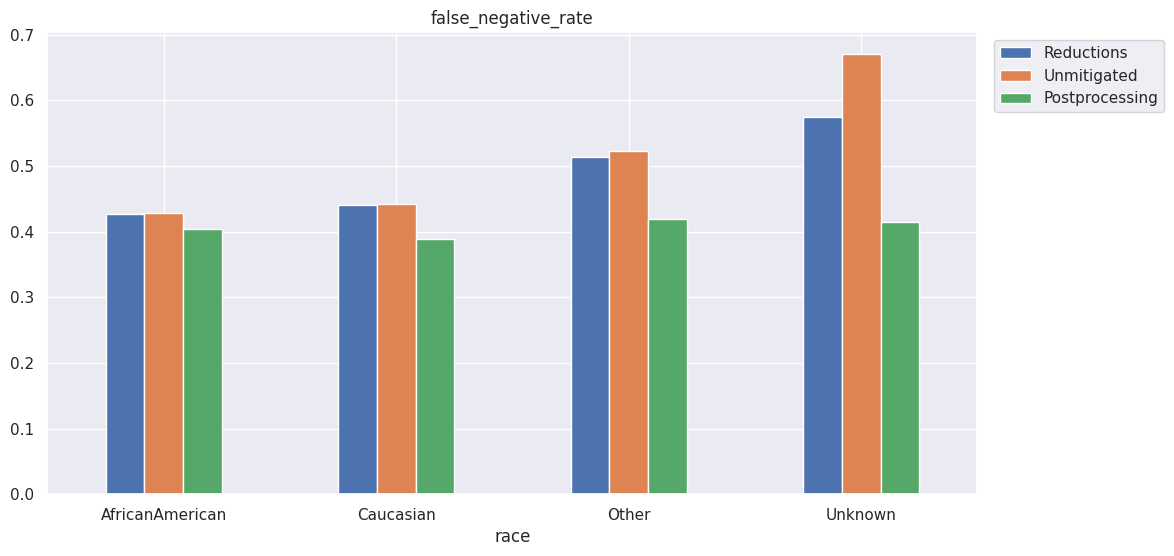

In [ ]:
plot_technique_comparison(test_dict, "false_negative_rate")

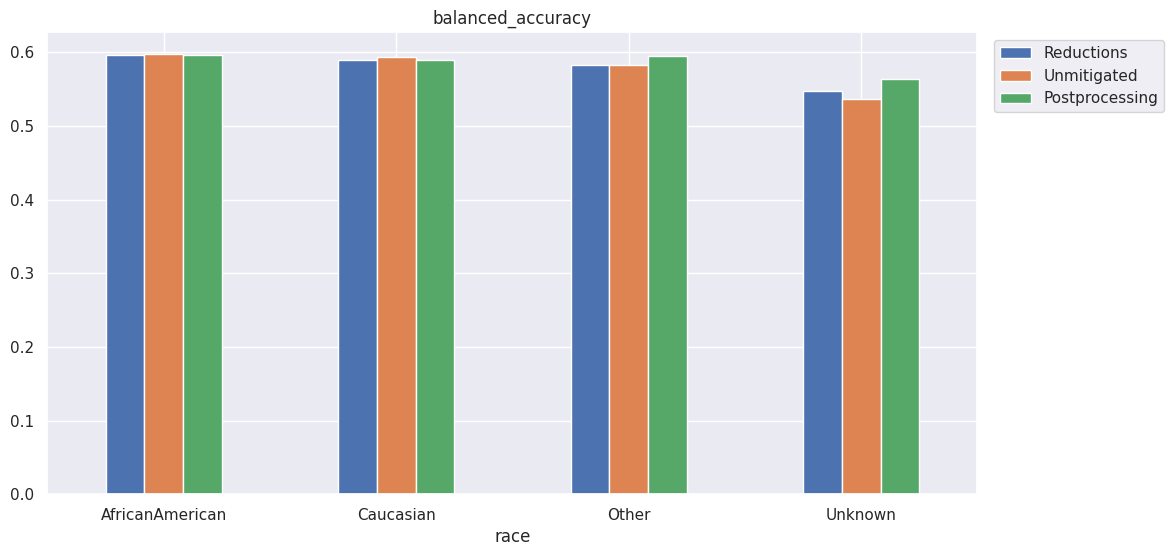

In [ ]:
plot_technique_comparison(test_dict, "balanced_accuracy")

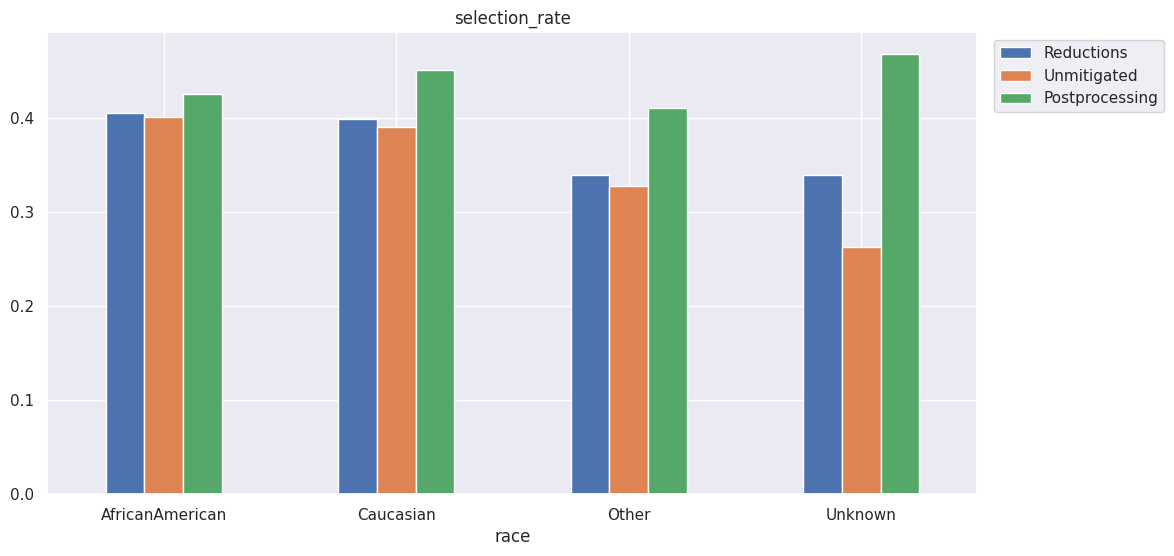

In [ ]:
plot_technique_comparison(test_dict, "selection_rate")

### Model Performance Overall

In [ ]:
overall_df = pd.DataFrame.from_dict({
    "Unmitigated": metricframe_unmitigated.overall,
    "Postprocessing": metricframe_postprocess.overall,
    "Reductions": metricframe_reductions.overall
})

In [ ]:
overall_df.T

,selection_rate,false_negative_rate,balanced_accuracy
Unmitigated,0.387,0.446,0.594
Postprocessing,0.445,0.393,0.591
Reductions,0.396,0.443,0.590


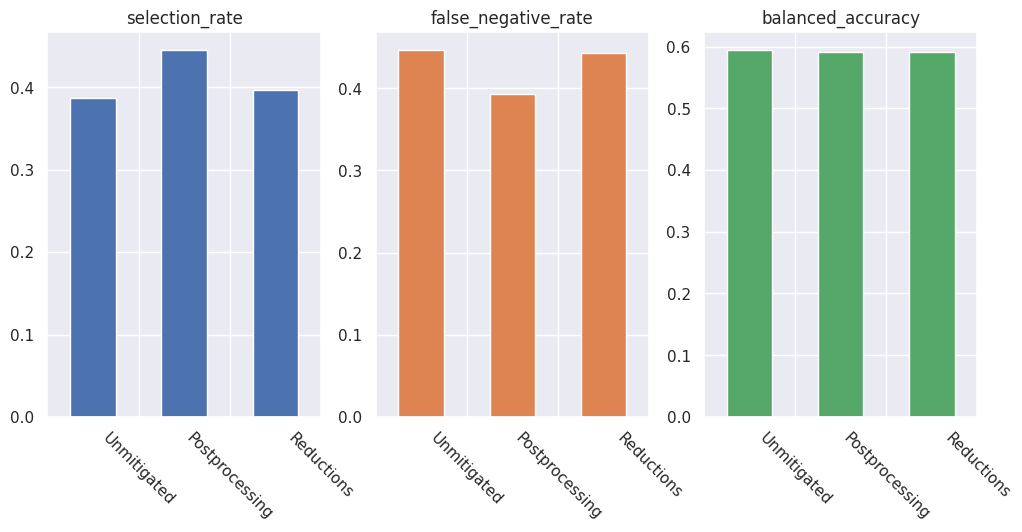

In [ ]:
overall_df.transpose().plot.bar(subplots=True, layout= [1,3], figsize=(12, 5), legend=False, rot=-45, position=1.5);

In [ ]:
difference_df = pd.DataFrame.from_dict({
    "Unmitigated": metricframe_unmitigated.difference(),
    "Postprocessing": metricframe_postprocess.difference(),
    "Reductions": metricframe_reductions.difference()
}
)

In [ ]:
difference_df.T

,selection_rate,false_negative_rate,balanced_accuracy
Unmitigated,0.137,0.242,0.061
Postprocessing,0.057,0.030,0.033
Reductions,0.066,0.148,0.049


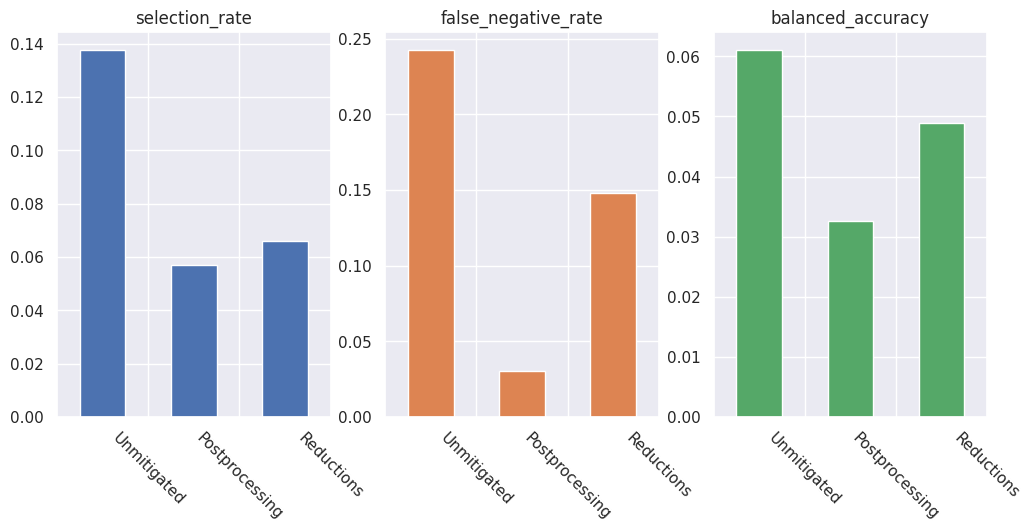

In [ ]:
difference_df.T.plot.bar(subplots=True, layout= [1,3], figsize=(12, 5), legend=False, rot=-45, position=1.5);

### Randomized Predictions
Both the `ExponentiatedGradient` and the `ThresholdOptimizer` yield randomized predictions (may return different result given the same instance). Due to legal regulations or other concerns, a practitioner may not be able to deploy a randomized model. To address these restrictions:

*   We can create a deterministic predictor (one without the randomized deployment) based on the randomized thresholds learned by the `ThresholdOptimizer`. This is done by interpolating a fixed threshold for each `sensitive_feature` in the `ThresholdOptimizer`.
*   For the `ExponentiatedGradient` model, we can deploy one of the deterministic inner models rather than the overall `ExponentiatedGradient` model.

### Access to sensitive features
*   The `ThresholdOptimizer` model requires access to the sensitive features during BOTH training time and once deployed. If you do not have access to the sensitive features once the model is deployed, you will not be able to use the `ThresholdOptimizer`.
*   The `ExponentiatedGradient` model requires access to the sensitive features ONLY during training time.





# Conclusion

In this lesson we have discussed the concept of algorithmic fairness in some depth, covered tools for identifying algorithmic unfairness, and some strategies for mitigating it with code.

The problem of algorithmic fairness is a sociotechnical one, however, and cannot be solved by code alone. Models that affect the lives of humans (e.g., predictive medicine, a job hiring application, or a loan approval system) have to be examined at every step of the ML process, and must be monitored carefully after deployment, in order to ensure fairness throughout the models' life cycle.

There is no silver bullet for algorithmic fairness, no one solution that will resolve the challenge for good and all. Instead, we as ML engineers and data scientists have to think long and hard, and then try to put our final systems  through some kind of third party evaluation to ensure the system is as fair as possible.